In [1]:
import pickle
import gzip
import numpy as np
import os
import time
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from matplotlib import pyplot as plt
from torchsummary import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
import torch.nn.functional as F
from unet import Unet

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

mac=True
if mac :
    device = torch.device("mps") # for silicon Mac
    PYTORCH_ENABLE_MPS_FALLBACK=1

print(f'Device used : {device}')

Device used : mps


In [3]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)

In [4]:
class TestDataset(Dataset):
    
    def __init__(self, video, transform=None):
        self.transform = transform
        self.images = video

    def __len__(self):
        return self.images.shape[2]#len(self.images)

    def __getitem__(self, idx):
        
        image = self.images[:, :, idx]
        
        transformed = self.transform(image=image)
        image = transformed["image"]
            
        return torch.div(image, 255).float()

In [5]:
test_to_tensor = A.Compose(
    [
        A.Resize(128, 128),
        A.augmentations.transforms.CLAHE(p=1),
        ToTensorV2()
    ]
)

In [6]:
test_data = load_zipped_pickle("data/test.pkl")

In [9]:
# need to load model (unet) as well
# code is not tested

# choose the version of the model
model_version='V01'

# choose the checkpoint from which to load the auto-encoder
epoch_load=150


# load model from checkpoint
unet = Unet(filters=8, kernel=3).to(device)
checkpoint = torch.load(f'model/model_{model_version}_epoch_{epoch_load}.pt')
unet.load_state_dict(checkpoint['model_state_dict'])
unet = unet.to(device)

# bring model to evaluation mode
unet.eval()

Unet(
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block_enc_1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): ReLU()
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
  )
  (block_enc_2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
  )
  (block_enc_3): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
  )
  (block_enc_4): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): ReLU()
   

In [10]:
# make prediction for test
predictions = []
for d in test_data:

    prediction = np.array(np.zeros_like(d['video']), dtype=bool)
    height = prediction.shape[0]
    width = prediction.shape[1]

    test_to_original = A.Compose([A.Resize(height, width)])

    video = d['video']
    test_dataset = TestDataset(video, test_to_tensor)

    test_loader = DataLoader(test_dataset, batch_size=16, pin_memory=True, shuffle=False)

    with torch.no_grad():
        out = torch.Tensor().to(device)
        for x in test_loader:
            x = x.to(device)
            #print(unet(x).shape)
            out = torch.cat((out, unet(x)),dim=0)


    out = out.cpu().numpy()

    #print(out[0].squeeze().shape)
        
    for i in range(out.shape[0]):
        prediction[:,:,i] = (test_to_original(image=out[i].squeeze())["image"]> 0.5)#.transpose(1, 2, 0)
    
    # DATA Strucure
    predictions.append({
        'name': d['name'],
        'prediction': prediction
        }
    )

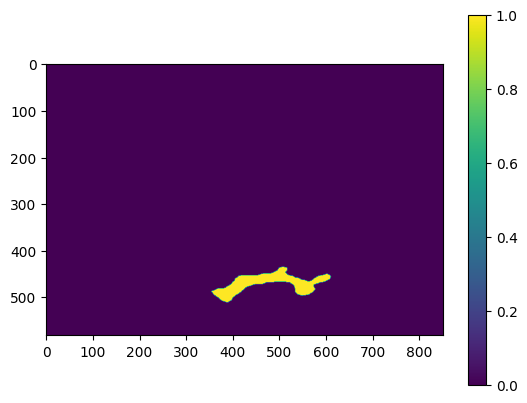

In [13]:
video = 3
frame = 10
plt.imshow(predictions[video]['prediction'][:,:,frame])
#plt.imshow(out[0].squeeze()> 0.5)
plt.colorbar()
plt.show()


In [12]:
# save in correct format
save_zipped_pickle(predictions, 'data/my_predictions.pkl')